# Quick start

PHIDL allows you to create complex designs from simple shapes, and can output the result as GDSII files. The basic element of PHIDL is the `Device`, which can be thought of as a blank area to which you can add polygon shapes. The polygon shapes can also have `Port`s on them--these allow you to snap shapes together like Lego blocks. You can either hand-design your own polygon shapes, or there is a large library of pre-existing shapes you can use as well.

## Creating a single shape

Let's start by trying to make a rectangle shape with ports on either end.

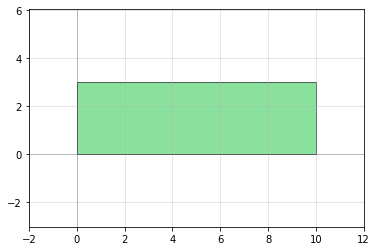

In [1]:
import numpy as np
from phidl import quickplot as qp
from phidl import Device
import phidl.geometry as pg


# First we create a blank device `R` (R can be thought of as a blank 
# GDS cell with some special features). Note that when we
# make a Device, we usually assign it a variable name with a capital letter
R = Device('rect')

# Next, let's make a list of points representing the points of the rectangle
# for a given width and height
width = 10
height = 3
points =  [(0, 0), (width, 0), (width, height), (0, height)]

# Now we turn these points into a polygon shape using add_polygon()
R.add_polygon(points)

# Let's use the built-in "quickplot" function to display the polygon we put in D
qp(R)

Next, let's add `Port`s to the rectangle which will allow us to connect it to other shapes easily

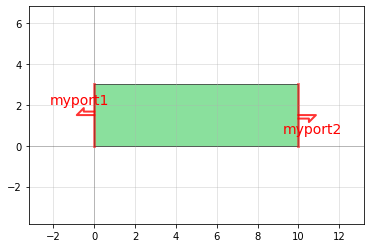

In [2]:
# Ports are defined by their width, midpoint, and the direction (orientation) they're facing
# They also must have a name -- this is usually a string or an integer
R.add_port(name = 'myport1', midpoint = [0,height/2], width = height, orientation = 180)
R.add_port(name = 'myport2', midpoint = [width,height/2], width = height, orientation = 0)

# The ports will show up when we quickplot() our shape
qp(R) # quickplot it!

We can check to see that our Device has ports in it using the `print` command:

In [3]:
print(R)

Device (name "rect" (uid 0),  ports ['myport1', 'myport2'], aliases [], 1 polygons, 0 references)


Looks good!

## Library & combining shapes

Since this Device is finished, let's create a new (blank) Device and add several shapes to it. Specifically, we will add an arc from the built-in geometry library and two copies of our rectangle Device.  We'll then then connect the rectangles to both ends of the arc.  The library is contained in `phidl.geometry` which as you can see at the top of this example is imported with the name `pg`.

This process involves adding "references".  These references allow you to create a Device shape once, then reuse it many times in other Devices. 

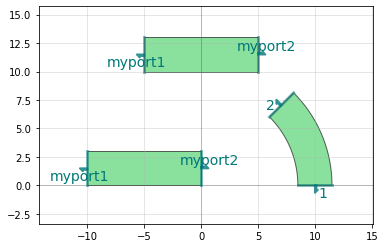

In [4]:
# Create a new blank Device
E = Device('arc_with_rectangles')

# Also create an arc from the built-in "pg" library
A = pg.arc(width = 3)

# Add a "reference" of the arc to our blank Device
arc_ref = E.add_ref(A)

# Also add two references to our rectangle Device
rect_ref1 = E.add_ref(R)
rect_ref2 = E.add_ref(R)

# Move the shapes around a little
rect_ref1.move([-10,0])
rect_ref2.move([-5,10])

qp(E) # quickplot it!

Now we can see we have added 3 shapes to our Device "E": two references to our rectangle Device, and one reference to the arc Device. We can also see that all the references have `Port`s on them, shown as the labels "myport1", "myport2", "1" and "2".

Next, let's snap everything together like Lego blocks using the `connect()` command.

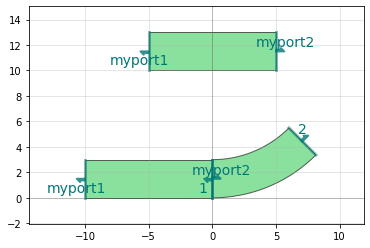

In [5]:
# First, we recall that when we created the references above we saved
# each one its own variable: arc_ref, rect_ref1, and rect_ref2
# We'll use these variables to control/move the reference shapes.

# First, let's move the arc so that it connects to our first rectangle.
# In this command, we tell the arc reference 2 things: (1) what port
# on the arc we want to connect, and (2) where it should go
arc_ref.connect(port = 1, destination = rect_ref1.ports['myport2'])

qp(E) # quickplot it!

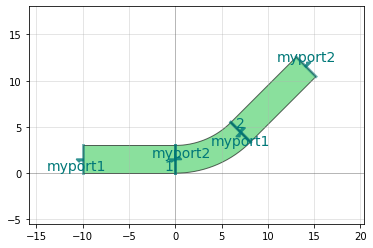

In [6]:
# Then we want to move the second rectangle reference so that
# it connects to port 2 of the arc
rect_ref2.connect('myport1', arc_ref.ports[2])

qp(E) # quickplot it!

Looks great!

## Going a level higher

Now we've made a (somewhat) complicated bend-shape from a few simple shapes.  But say we're not done yet -- we actually want to combine together 3 of these bend-shapes to make an even-more complicated shape.  We could recreate the geometry 3 times and manually connect all the pieces, but since we already put it together once it will be smarter to just reuse it multiple times.

We will start by abstracting this bend-shape.  As shown in the quickplot, there are ports associated with each reference in our bend-shape Device `E`: "myport1", "myport2", "1", and "2".  But when working with this bend-shape, all we really care about is the 2 ports at either end -- "myport1" from `rect_ref1` and "myport2" from `rect_ref2`. It would be simpler if we didn't have to keep track of all of the other ports.

First, let's look at something: let's see if our bend-shape Device `E` has any ports in it:

In [7]:
print(E)

Device (name "arc_with_rectangles" (uid 1),  ports [], aliases [], 0 polygons, 3 references)


It has no ports apparently!  Why is that, when we clearly see ports in the quickplots above?

The answer is that Device `E` *itself* doesn't have ports -- the references inside `E` do have ports, but we never actually added ports to `E`.  Let's fix that now, adding a port at either end, setting the names to the integers 1 and 2.

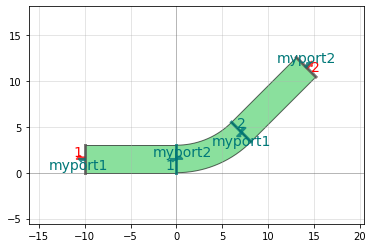

In [8]:
# Rather than specifying the midpoint/width/orientation, we can instead
# copy ports directly from the references since they're already in the right place
E.add_port(name = 1, port = rect_ref1.ports['myport1'])
E.add_port(name = 2, port = rect_ref2.ports['myport2'])

qp(E) # quickplot it!

If we look at the quickplot above, we can see that there are now red-colored ports on both ends.  Ports that are colored red are owned by the Device, ports that are colored blue-green are owned by objects inside the Device. This is good!  Now if we want to use this bend-shape, we can interact with its ports named 1 and 2.  

Let's go ahead and try to string 3 of these bend-shapes together:

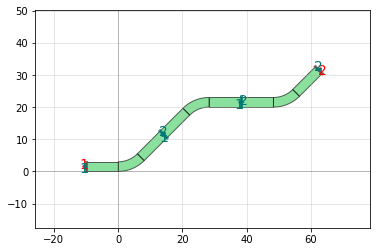

In [9]:
# Create a blank Device
D = Device('triple-bend')

# Add 3 references to our bend-shape Device `E`:
bend_ref1 = D.add_ref(E)  # Using the function add_ref()
bend_ref2 = D << E        # Using the << operator which is identical to add_ref()
bend_ref3 = D << E

# Let's mirror one of them so it turns right instead of left
bend_ref2.mirror()

# Connect each one in a series
bend_ref2.connect(1, bend_ref1.ports[2])
bend_ref3.connect(1, bend_ref2.ports[2])

# Add ports so we can use this shape at an even higher-level
D.add_port(name = 1, port = bend_ref1.ports[1])
D.add_port(name = 2, port = bend_ref3.ports[2])

qp(D) # quickplot it!

## Saving as a GDSII file

Saving the design as a GDS file is simple -- just specify the Device you'd like to save and run the `write_gds()` function:

In [10]:
D.write_gds('triple-bend.gds')

'triple-bend.gds'

Some useful notes about writing GDS files:

- The default unit is  1e-6 (micrometers aka microns), with a precision of 1e-9 (nanometer resolution)
- PHIDL will automatically handle naming of all the GDS cells to avoid name-collisions.
- Unless otherwise specified, the top-level GDS cell will be named "toplevel"

All of these parameters can be modified using the appropriate arguments of `write_gds()`:

In [11]:
D.write_gds(filename = 'triple-bend.gds', # Output GDS file name
            unit = 1e-6,                  # Base unit (1e-6 = microns)
            precision = 1e-9,             # Precision / resolution (1e-9 = nanometers)
            auto_rename = True,           # Automatically rename cells to avoid collisions
            max_cellname_length = 28,     # Max length of cell names
            cellname = 'toplevel'         # Name of output top-level cell
           )

'triple-bend.gds'